In [1]:
from spacy.tokens import DocBin
from ml_datasets import imdb
from tqdm import tqdm
import matplotlib.pyplot as plt
import spacy
import pandas as pd
import seaborn as sns

In [2]:
train_data, valid_data = imdb()

In [3]:
df_train = pd.DataFrame(train_data, columns =['Review', 'Sentiment'])
df_validation = pd.DataFrame(valid_data, columns =['Review', 'Sentiment'])

In [4]:
df_train.head()

,Review,Sentiment
0,"The first time I saw this film, I was in shock...",pos
1,I caught this movie on Sci-Fi before heading i...,neg
2,As I said in my comment about the first part: ...,pos
3,"I grew up on this classic western series, and ...",pos
4,"49. PAPERHOUSE (thriller/horror, 1988) Sick in...",pos


In [5]:
df_train['Sentiment'].unique()

array(['pos', 'neg'], dtype=object)

<AxesSubplot: xlabel='Sentiment', ylabel='count'>

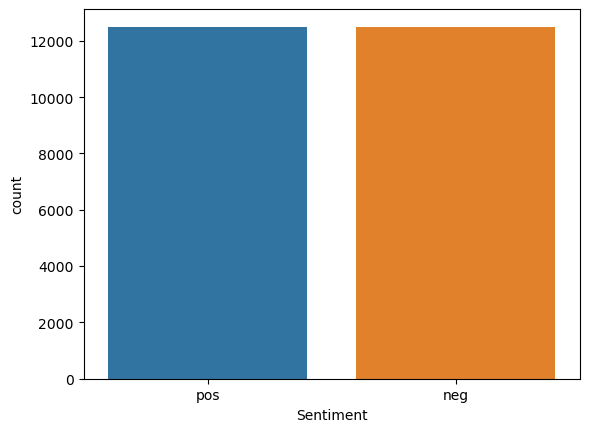

In [6]:
sns.countplot(x=df_train['Sentiment'])

## Preprocessing Text

In [7]:
def remove_new_line(text):
    return text.replace('\n', ' ')

In [8]:
df_train['Review'] = df_train['Review'].apply(remove_new_line)
df_validation['Review'] = df_validation['Review'].apply(remove_new_line)

## Create spaCy Docs

In [9]:
nlp = spacy.load('en_core_web_sm')

In [10]:
def make_docs(dataframe):
    docs = []
    data = list(dataframe.itertuples(index=False, name=None))
    
    for doc, label in tqdm(nlp.pipe(data, as_tuples=True), total=len(data)):
        if label == 'pos':
            doc.cats['positive'] = 1
            doc.cats['negative'] = 0
        else:
            doc.cats['positive'] = 0
            doc.cats['negative'] = 1
        docs.append(doc)
    
    return docs

In [11]:
training_number = 1000

train_docs = make_docs(df_train[:training_number])
doc_bin = DocBin(docs=train_docs)
doc_bin.to_disk('./data/train.spacy')

valid_docs = make_docs(df_validation[:training_number])
doc_bin = DocBin(docs=valid_docs)
doc_bin.to_disk('./data/valid.spacy')

100%|██████████| 1000/1000 [00:24<00:00, 40.77it/s]


## Create Training Config
Create a base config file using spaCy's [online config generator](https://spacy.io/usage/training#quickstart).
Select `textcat` as Component and exclusive categories. Choosing exlucsive categories will lead to prediction of one and only one category. Leave Hardware as CPU since we're using a non-transformer architecture. Copy the generated config to `base_config.cfg`

In [12]:
!python -m spacy init fill-config ./base_config.cfg ./config.cfg

✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [13]:
!python -m spacy train config.cfg --output ./output

ℹ Saving to output directory: output
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2022-10-08 21:21:49,015] [INFO] Set up nlp object from config
[2022-10-08 21:21:49,022] [INFO] Pipeline: ['textcat']
[2022-10-08 21:21:49,024] [INFO] Created vocabulary
[2022-10-08 21:21:49,024] [INFO] Finished initializing nlp object
[2022-10-08 21:21:52,354] [INFO] Initialized pipeline components: ['textcat']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['textcat']
ℹ Initial learn rate: 0.001
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------
  0       0          0.25       32.80    0.33
  0     200         63.69       53.41    0.53
  0     400         45.57       76.70    0.77
  0     600         29.05       78.57    0.79
  0     800         32.15       80.66    0.81
  1    1000         29.66       77.30    0.77
  1    1200          2.54       81.1

## Testing

In [14]:
nlp = spacy.load('./output/model-best')

In [15]:
text = df_train.at[6000, 'Review']
label_true = df_train.at[6000, 'Sentiment']

In [16]:
doc = nlp(text)

In [17]:
print(doc.cats)
print(label_true)

{'positive': 0.0028896566946059465, 'negative': 0.9971103668212891}
neg
